23125 80000


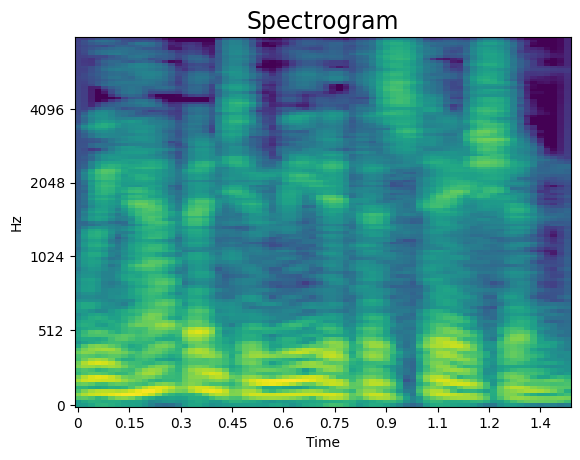

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
# 一些聲音相關參數，以5秒為一個音檔單位
FOLDS = 10
SEED = 101
DEBUG = True

# Audio params
SAMPLE_RATE = 16000 # 這個參數表示音訊的採樣率，即每秒採集的樣本數。在這個例子中，採樣率為 16000 Hz，表示每秒會有 16000 個樣本。
DURATION = 5.0 # duration in second # 這個參數表示音訊的持續時間，單位為秒。在這個例子中，音訊的持續時間為 5 秒。
AUDIO_LEN = int(SAMPLE_RATE * DURATION) 
# 這個參數計算了音訊數據的總長度，以樣本數表示。由於採樣率為 16000 Hz，持續時間為 5 秒，因此音訊數據的總長度為 16000 * 5 = 80000 個樣本。

# Spectrogram params
N_MELS = 128 # freq axis
N_FFT = 2048
SPEC_WIDTH = 256 # time axis
HOP_LEN = AUDIO_LEN//(SPEC_WIDTH - 1) # non-overlap region
FMAX = SAMPLE_RATE//2 # max frequency
SPEC_SHAPE = [SPEC_WIDTH, N_MELS] # output spectrogram shape


def load_audio(filepath, sr=SAMPLE_RATE): # load the audio
    audio, sr = librosa.load(filepath, sr=sr)
    return audio, sr

def plot_audio(audio, sr=SAMPLE_RATE): # 繪製時域上的圖
    fig = librosa.display.waveshow(audio, axis='time', sr=sr)
    return fig

def get_spectrum(audio, sr=SAMPLE_RATE): # 繪製頻域上的圖
    sp = np.fft.fft(audio)
    ampSP = np.abs(sp)
    
    # Calculate the frequency axis
    freq_axis = np.fft.fftfreq(len(sp), 1/sr)
    
    # the magnitude spectrum
    fig = plt.plot(freq_axis[:len(freq_axis)//2], ampSP[:len(freq_axis)//2])  # Only plot the positive frequencies
    return fig

def listen_audio(audio, sr=SAMPLE_RATE): # 聽音檔
    ipd.display(ipd.Audio(audio, rate=sr))
    
def get_mel_spectrogram(audio, sr=SAMPLE_RATE): # get the mel-spectrogram
    # same as ######
    # D = np.abs(librosa.stft(y))**2
    # S = librosa.feature.melspectrogram(S=D, sr=sr)
    ################
    spec = librosa.feature.melspectrogram(y=audio, sr=sr, fmax=FMAX, n_mels=N_MELS, hop_length=HOP_LEN, n_fft=N_FFT)
    spec = librosa.power_to_db(spec)
    return spec

def plot_mel_spectrogram(spec, sr=SAMPLE_RATE): # get the display fig of mel-spectrogram
    # 文獻中提到viridis - blue to green to yellow -> best performing
    # yellow: 越大 / blue: 越小
    fig = librosa.display.specshow(spec, x_axis='time', y_axis='mel', hop_length=HOP_LEN, sr=sr, fmax=FMAX, cmap='viridis')
    
    return fig


# load audio 已經固定sample rate
# def resample_if_necessary(audio, sr):
#     if sr != SAMPLE_RATE:
#         audio = librosa.core.resample(audio, sr, SAMPLE_RATE)
#     return audio
def plot_all(audio): # 開始繪製時域圖、頻域圖、時頻譜
    # 聽音檔
    print('# Listen')
    listen_audio(audio)

    # 開始繪製時域圖、頻域圖、時頻譜
    print("# Plot\n")
    plt.figure(figsize=(18, 5))

    plt.subplot(121)
    plot_audio(audio)
    plt.title("Waveform",fontsize=17)

    plt.subplot(122)
    get_spectrum(audio)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Magnitude Spectrum')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    spec = get_mel_spectrogram(audio) 
    # normalize ###
    # spec = normalize_audio(spec)
    ###############
    plot_mel_spectrogram(spec)
    plt.title("Spectrogram",fontsize=17)
    plt.show()

#  資料前處理
# 利用threshold濾掉能量過小的樣本
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10),
                       min_periods=1,
                       center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean

# Min-Max正規化
def normalize_audio(audio):
    return (audio - np.min(audio)) / (np.max(audio) - np.min(audio))

if __name__ == "__main__":
        filepath = r"D:\FoR\FoR_for_norm\for-norm\training\fake\file3.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav"
        audio, sr = load_audio(filepath, sr=SAMPLE_RATE)
        listen_audio(audio)
        print(len(audio), AUDIO_LEN)
        audio = audio[:AUDIO_LEN]
        # delete the low energy part
        mask, _ = envelope(audio, sr, threshold = 0.0005)  # can adjust the threshold
        # audio = audio[mask]
        spec = get_mel_spectrogram(audio)
        # min-max the spec
        # spec = normalize_audio(spec)
        fig = plot_mel_spectrogram(spec)
        plt.title("Spectrogram", fontsize=17)
        plt.show()